# Two forest meathod for WW selection ( selection cuts inspired by the CMS Higg &rarr; WW method)

Oct. 21 

We select WW using a convolution of two random forest. We preform a preselection on the data removing the Z peak, b jets and extra leptons. We performed this analysis on sub-leading lepton pt greater than 10 GeV selection. We find that we an easily recreate and exceed the yield quoted by CMS. 

Future:

Validate RF results in data. 

# MC Set-up

In [1]:
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

In [2]:
run ../prep_ana.py

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading plotting specs...
8 or 13 TeV:
Loading 8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?True
Correct MET?True
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [3]:
%matplotlib inline

In [4]:
def process_yields( df ):
    for process in df.process.unique():
        for decay in df[df.process == process].process_decay.unique():
            if decay in scales.keys():
                print process, decay, df[(df.process_decay==decay)].shape[0], df[(df.process_decay==decay)].shape[0] * scales[decay]

In [5]:
# Concate processes and preform preselection
df_train_test = pre_cuts(df, diff_charge=False)
df_train_test = df_train_test.reset_index()

In [6]:
process_yields( df_train_test )

DY DYJetsToLL_M-50 283081 659572.750537
DY DYJetsToLL_M-10to50 17183 138955.035501
WW WW 108938 12275.0405378
Top ttbar_leptonic 604764 23040.2946455
Top ttbar_semileptonic 2735 232.459509108
Top Tbar_s-channel 4 1.38688
Top Tbar_t-channel 69 21.565352607
Top Tbar_tW-channel 4040 1802.68932842
Top T_s-channel 10 2.40906520593
Top T_t-channel 160 47.3023050497
Top T_tW-channel 4114 1820.2237412
ZZ ZZJetsTo2L2Q 20918 525.551077669
ZZ ZZJetsTo2L2Nu 12534 183.59099225
WZ WZJetsTo3LNu 135770 1418.19901496
WZ WZJetsTo2L2Q 34884 478.658562993
WG WGToLNuG 249 1471.59
WJ W1JetsToLNu 212 1204.46652814
WJ W2JetsToLNu 485 606.71075
WJ W3JetsToLNu 338 274.935741935
WJ W4JetsToLNu 395 154.459849624


In [7]:
#Select a subset of events that will be used for training and testing

#train_DY = df_train_test[df_train_test.process=="DY"].sample( frac=0.4 )
train_WW = df_train_test[df_train_test.process=="WW"].sample( frac=0.4)#n=train_DY.shape[0]*2 )
train_DY = df_train_test[df_train_test.process=="DY"].sample( n=train_WW.shape[0]*2  )#.45
train_TT = df_train_test[df_train_test.process=="Top"].sample( n=train_WW.shape[0]*2 )

train_fTT = pd.concat( [train_WW, train_TT, ] )
train_fDY = pd.concat( [train_WW, train_DY])

print train_DY.shape
print train_WW.shape
print train_TT.shape

(87150, 68)
(43575, 68)
(87150, 68)


In [8]:
test = df_train_test.drop( train_fTT.index )
test = test.drop(train_DY.index )
print train_fDY.shape, test.shape

print test[test.process == "WW"].shape
print test[test.process == "DY"].shape
print test[test.process == "Top"].shape

(130725, 68) (1062624, 68)
(65363, 68)
(262730, 68)
(528746, 68)


# Data Set-up 

In [10]:
df_da_a = rp.read_root(data_path+"/muon_2012A_complete.root")
df_da_b = rp.read_root(data_path+"/muon_2012B_complete.root")
df_da_c = rp.read_root(data_path+"/muon_2012C_complete.root")
df_da_d = rp.read_root(data_path+"/muon_2012D_complete.root")

df_da = pd.concat([df_da_a, df_da_b, df_da_c, df_da_d])

In [11]:
df_da_pre = pre_cuts(df_da, diff_charge=False)

# pre-cut yield check

(<matplotlib.figure.Figure at 0x1296f3510>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x12971c850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12bc070d0>], dtype=object))

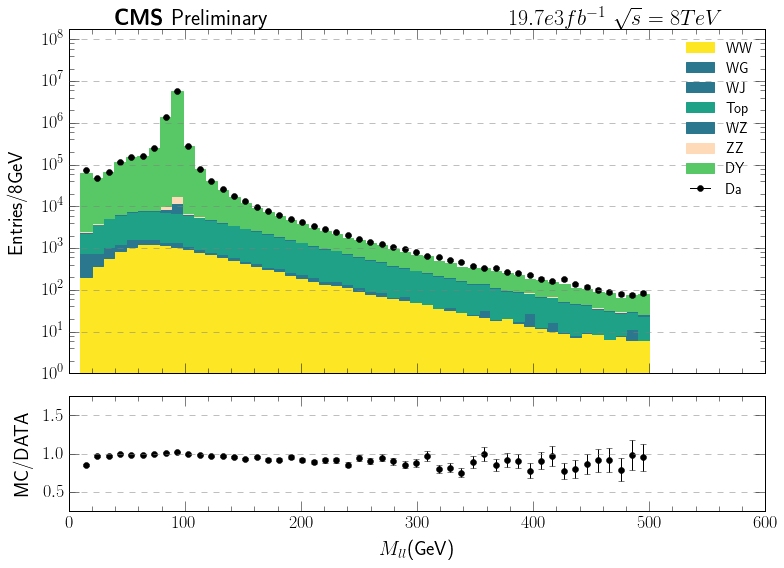

In [15]:
bins_mc = bin_df( df, "mll", range=(10,500), scales=scales, bins=50)
bins_da = bin_df( df_da, "mll", range=(10,500), bins=50 )

full_plot( bins_mc, bins_da)

(<matplotlib.figure.Figure at 0x131da9090>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x131dd5e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1e2366490>], dtype=object))

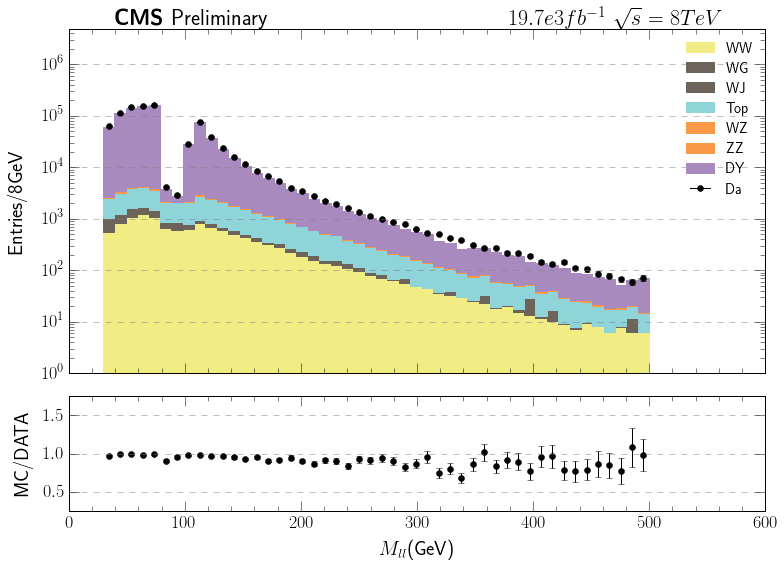

In [11]:

bins_mc = bin_df( df_train_test, "mll", range=(10,500) , scales=scales, bins=50)
bins_da = bin_df( df_da_pre, "mll", range=(10,500), bins=50 )

full_plot( bins_mc, bins_da, color="color_1")

# Features, Weights, and Labels

In [12]:
#features_fDY = ['numb_jets', 'metMod', 'qT', 'jet1_pt', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type']
#features_fDY = ['metMod', 'qT', 'jet1_pt', 'dPhiLLMET', 'dPhiMETJet',\
#                'lep_Type', 'METProj_sin_', 'mllMET']
features_fDY =['mll', 'lep_Type', 'lep1_pt', 'METProj', 'jet1_pt', 'dPhiLL', 'qT', 'HT', 'dPhiLLMET']
#features_fDY = ['numb_jets', 'met_corrected', 'qT', 'jet1_pt', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type']
#features_fDY = ['numb_jets', 'met_corrected_', 'qT', 'jet1_pt', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type']
#['numb_jets', 'METProj_sin', 'met_over_sET','METProj_trk_sin', 'qT', 'mllMET', 'recoil', 'jet1_pt', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type']
features_fTT = ['numb_jets', 'lep2_pt', 'METProj', 'qT', 'mll', 'mllMET', 'metMod', 'dPhiLLMET', 'dPhiLLJet', 'dPhiMETJet', 'dPhiLL', 'HT', 'recoil'] +\
           ['jet1_csv', 'lep_Type']

In [13]:
#Create labels 
#labels TT
labels_fTT = np.empty( train_fTT.shape[0] )
weights_fTT = np.empty( train_fTT.shape[0])

labels_fTT[(train_fTT.process == "WW").as_matrix()] = 1
labels_fTT[(train_fTT.process == "Top").as_matrix()] = 2

weights_fTT[(train_fTT.process == "WW").as_matrix()] = 1
weights_fTT[(train_fTT.process == "Top").as_matrix()] = 1

#labels DY
labels_fDY = np.empty( train_fDY.shape[0] )
weights_fDY = np.empty( train_fDY.shape[0])

labels_fDY[(train_fDY.process == "WW").as_matrix()] = 1
labels_fDY[(train_fDY.process == "DY").as_matrix()] = 2

weights_fDY[(train_fDY.process == "WW").as_matrix()] = 1
weights_fDY[(train_fDY.process == "DY").as_matrix()] = 1

In [14]:
#Set up random forest for Drell Yan and TTBar selections

clf_fTT = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_fTT = clf_fTT.fit( np.float32(train_fTT[features_fTT].values) , np.float32(labels_fTT), )#sample_weight=weights_fTT)

clf_fDY = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_fDY = clf_fDY.fit( np.float32(train_fDY[features_fDY].values) , np.float32(labels_fDY), )#sample_weight=weights_fDY)

#Print scores
print "TTbar training score", clf_fTT.score(np.float32(train_fTT[features_fTT].values), np.float32(labels_fTT), weights_fTT)
print "Drell Yan training score", clf_fDY.score(np.float32(train_fDY[features_fDY].values), np.float32(labels_fDY), weights_fDY)

TTbar training score 0.928460508701
Drell Yan training score 0.952648689998


In [ ]:
#test = df_train_test.drop( train_fTT.index )
#test = test.drop(train_DY.index )

In [15]:
#Predict test set Drell Yan and TTbar samples
pred_fTT = clf_fTT.predict_proba(np.float32(test[features_fTT].values))
test["pred_fTT_WW"] = pred_fTT[:,0]

pred_fDY = clf_fDY.predict_proba(np.float32(test[features_fDY].values))
test["pred_fDY_WW"] = pred_fDY[:,0]

# Results

In [16]:
scales_test = {key: scales[key] * ( float(df_train_test[ df_train_test.process_decay == key].shape[0])/ float(test[ test.process_decay == key].shape[0]) ) for key in scales.keys() if key in df_train_test.process_decay.unique() } 

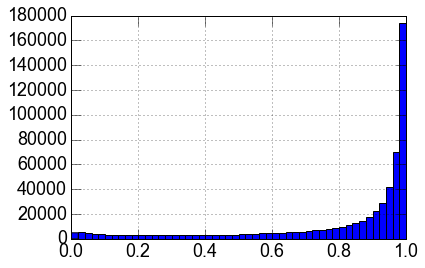

In [40]:
for key in scales.keys():
    if key not in scales_test.keys():
        scales_test[key] = scales[key]
scales_test

In [30]:
#Predict on data set
features_fDY_da = ['metMod', 'qT', 'jet1_pt', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type', 'METProj_sin', 'mllMET']

pred_fTT = clf_fTT.predict_proba(np.float32(df_da_pre[features_fTT].values))
df_da_pre["pred_fTT_WW"] = pred_fTT[:,0]

pred_fDY = clf_fDY.predict_proba(np.float32(df_da_pre[features_fDY].values))
df_da_pre["pred_fDY_WW"] = pred_fDY[:,0]

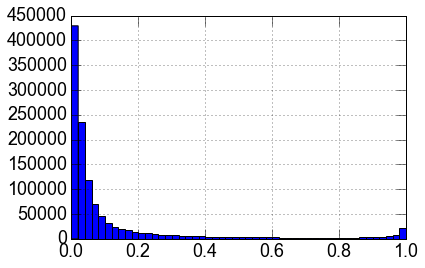

In [47]:
#plot the two results in a set of plots
df_da_pre.pred_fDY_WW.hist(bins=50)

df_da_pre.pred_fTT_WW.hist(bins=50)

(<matplotlib.figure.Figure at 0x1cc009450>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1cc6a1250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1ce553550>], dtype=object))

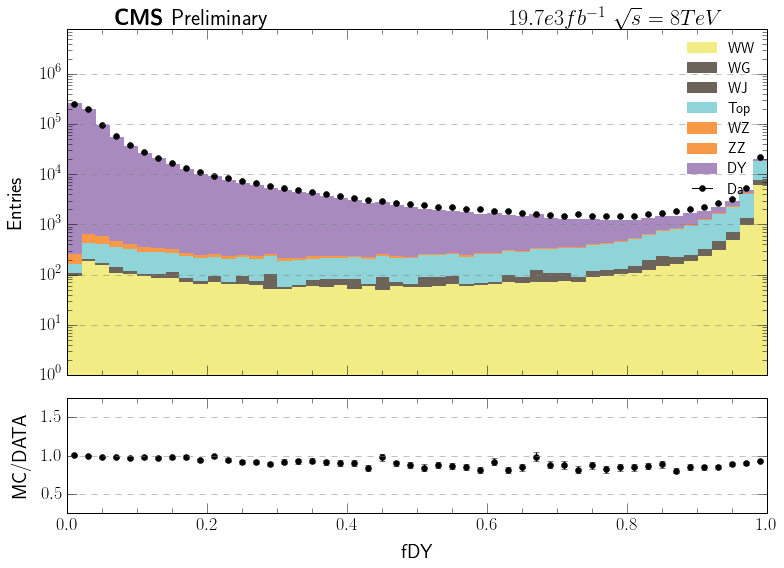

In [23]:
#df_da_pre = df_da_pre[ df_da_pre.mll >= 50 ]
bins_mc = bin_df( test[ test.mll > 30], "pred_fDY_WW", range=(0,1), bins=50, scales=scales_test)
bins_da = bin_df( df_da_pre[ df_da_pre.mll > 30], "pred_fDY_WW", range=(0,1), bins=50)

full_plot( bins_mc, bins_da, color="color_1", title="fDY", x_range=(-1,1.3))

(<matplotlib.figure.Figure at 0x13f047c50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x13eee0450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1d4534890>], dtype=object))

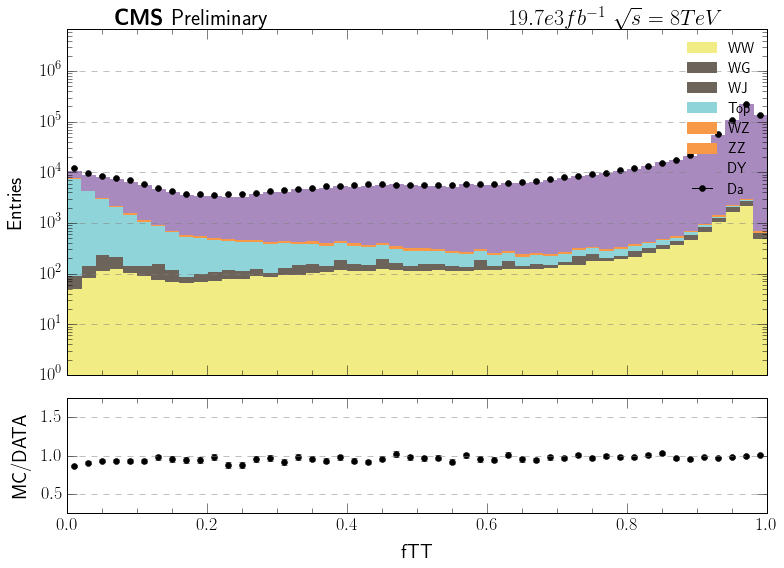

In [27]:
bins_mc = bin_df( test[ test.mll > 30], "pred_fTT_WW", range=(0,1), bins=50, scales=scales_test)
bins_da = bin_df( df_da_pre[ df_da_pre.mll > 30], "pred_fTT_WW", range=(0,1), bins=50)

full_plot( bins_mc, bins_da, color="color_1", title="fTT", x_range=(-1,1.3))

(<matplotlib.figure.Figure at 0x1cc0df690>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c95af550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c979b890>], dtype=object))

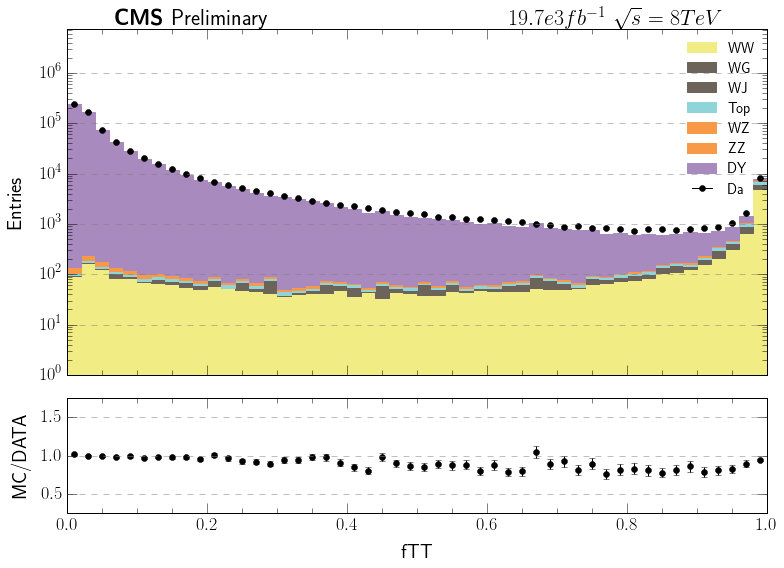

In [26]:
rf_cut = 0.65

bins_mc = bin_df( test[ (test.mll > 30) & (test.pred_fTT_WW > rf_cut )], "pred_fDY_WW", range=(0,1), bins=50, scales=scales_test)
bins_da = bin_df( df_da_pre[ (df_da_pre.mll > 30) & (df_da_pre.pred_fTT_WW > rf_cut)], "pred_fDY_WW", range=(0,1), bins=50)

full_plot( bins_mc, bins_da, color="color_1", title="fTT", x_range=(-1,1.3))

In [ ]:
cut = 0.35
feature_cuts =  (test.pred_fTT_WW > cut) & (test.numbExtraLep == 0) & (test.numb_jets < 2)
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test.lep_Type < 0) & feature_cuts #& (test.METProj_trk_sin > 30)
print "\tdiff", "\tsame"
for process in scales.keys():
    if process in test.process_decay.unique():
        print process, test[ (test.process_decay == process) & feature_cuts_diff].shape[0] * scales_test[process],\
    test[ (test.process_decay == process) & feature_cuts_same].shape[0] *scales_test[process]

In [ ]:
cut = 0.8
feature_cuts =  (test.pred_fDY_WW > cut) & (test.numbExtraLep == 0) & (test.numb_jets < 2)
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test.lep_Type < 0) & feature_cuts #& (test.METProj_trk_sin > 30)
print "\tdiff", "\tsame"
for process in scales.keys():
    if process in test.process_decay.unique():
        print process, test[ (test.process_decay == process) & feature_cuts_diff].shape[0] * scales_test[process],\
    test[ (test.process_decay == process) & feature_cuts_same].shape[0] *scales_test[process]

In [25]:
cut_tt = 0.65
cut_dy = .972
feature_cuts =  (test.pred_fTT_WW > cut_tt) & (test.pred_fDY_WW > cut_dy) & (test.numbExtraLep == 0) & (test.mll > 50)
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test.lep_Type < 0) & feature_cuts #& (test.METProj_trk_sin > 30)
print "\tdiff", "\tsame"
same_yields = 0
diff_yields = 0
for process in scales.keys():
    if process in test.process_decay.unique():
        diff_yields_ = test[ (test.process_decay == process) & feature_cuts_diff].shape[0] * scales_test[process]
        same_yields_ = test[ (test.process_decay == process) & feature_cuts_same].shape[0] *scales_test[process]
        print process, diff_yields_, same_yields_
        diff_yields += diff_yields_
        same_yields += same_yields_

	diff 	same
ttbar_semileptonic 0.895222756512 0.099469195168
WZJetsTo3LNu 185.942112876 50.1493221684
W1JetsToLNu 426.108441558 0.0
WGToLNuG 407.79 0.0
Tbar_t-channel 0.756679038843 0.0
DYJetsToLL_M-50 400.614375803 149.065814252
W2JetsToLNu 85.0646 1.25095
T_tW-channel 122.238501808 22.5987146199
DYJetsToLL_M-10to50 0.0 0.0
T_s-channel 0.0 0.0
ttbar_leptonic 422.163692078 97.7637562964
Tbar_s-channel 0.0 0.0
W3JetsToLNu 27.6562580645 0.0
W4JetsToLNu 5.47452631579 0.0
ZZJetsTo2L2Q 0.22611911746 0.125621731922
Tbar_tW-channel 125.986053151 36.2922786854
WW 3873.709303 786.873611266
WZJetsTo2L2Q 0.219542971216 0.109771485608
T_t-channel 3.94185875414 0.716701591662
ZZJetsTo2L2Nu 2.50471195745 30.1004858044


In [80]:
feature_cuts =  (df_da_pre.pred_fTT_WW > cut_tt) & (df_da_pre.pred_fDY_WW > cut_dy) & (df_da_pre.numbExtraLep == 0) & (df_da_pre.mll > 30)
feature_cuts_diff =( df_da_pre.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (df_da_pre.lep_Type < 0) & feature_cuts

print "Same:", df_da_pre[ feature_cuts_same ].shape
print "Diff:", df_da_pre[ feature_cuts_diff ].shape

Same: (1944, 65)
Diff: (6607, 65)


In [ ]:
print "Same", 1953 - same_yields , same_yields
print "Diff", 6345 - diff_yields - (54+54+189+81+125+75+63+114+36+18+28+33+220), diff_yields
472. / 3900.

# DiForest analysis

We wish to formulize our search through the 2 tree phase space. We develope a statistic, yield asymetry, to quantize how the trees perform under a specific combination of cuts. We define this yield as (WW - BKG) / (WW + BKG).  We can compute the CMS yield asymetry from quoted yields as .346. We also define a seperate statistic the normalized uncertainty, defined by  UNC / min_UNC. 

WW : 4629+1776

DY : 206 + 174 

TT : 1920 + 810
     

In [ ]:
def two_tree_process_map( df, pred_names, bins=10, scales=scales):
    bins_i = bins
    bins_j = bins
    if type(bins) == tuple:
        bins_i = bins[0]
        bins_j = bins[1]
    results = {}

    for decay in df.process_decay.unique():
        ax_i = np.array([ float(i) / float(bins_i) for i in xrange(bins_i)])
        ax_j = np.array([ float(j) / float(bins_j) for j in xrange(bins_j)])
        a= df[df.process_decay == decay][pred_names[0]].values.reshape( (df[df.process_decay == decay].shape[0], 1) ) > ax_i
        b= df[df.process_decay == decay][pred_names[1]].values.reshape( (df[df.process_decay == decay].shape[0], 1) ) > ax_j
        ones = np.ones((ax_i.shape[0],df[df.process_decay == decay].shape[0],1), dtype=np.bool)
        a_ = ones == a
        results_ = a_ & (b.transpose().reshape((ax_i.shape[0],df[df.process_decay == decay].shape[0],1)) == np.ones((df[df.process_decay == decay].shape[0],ax_i.shape[0])))
        if decay in scales.keys():
            if process in results.keys(): 
                print "if ", process,  decay
                results[decay] += results_.sum(axis=1) * scales[decay]
            else:
                print decay
                results[decay] = results_.sum(axis=1) * scales[decay]
    return results, [ax_i,ax_j]

In [ ]:
def yield_asymetry( process_map, df):
    results = {}
    process_names = ["WW", "DY", "Top"]
    for process in process_names:
        for decay in process_map[0].keys():
            if process in df[ df.process_decay == decay].process.unique():
                if process not in results:
                    results[process] = process_map[0][decay]
                else:
                    results[process] += process_map[0][decay]
    #results = (process_map[0]["WW"] - (process_map[0]["DY"] + process_map[0]["Top"])) / (process_map[0]["WW"] + process_map[0]["DY"] + process_map[0]["Top"])
    results_Numerator = results["WW"] - ( results["DY"] + results["Top"])
    results_Denominator = results["WW"] + results["DY"] + results["Top"]
    return results_Numerator / results_Denominator, process_map[1]

In [ ]:
two_tree_map =two_tree_process_map( test, ["pred_fTT_WW", "pred_fDY_WW"], bins=50, scales=scales_test)
two_tree_yield = yield_asymetry( two_tree_map, test )

In [ ]:
fig, ax = plt.subplots(figsize=(11,9))
yield_map = ax.pcolor(two_tree_yield[0])#[35:,10:])
plt.colorbar(yield_map)
plt.xticks([i for i in range( len(two_tree_yield[1][0])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][0]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_yield[1][1])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][1]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")


In [ ]:
unc_mc_process = {}#{ "WW": .05, "DY": .03, "TT": 0.05, "ZZ": 0.1, "WZ":.1 }
for key in plotting_options.process_decay.unique():
  unc_mc_process[key] = plotting_options[plotting_options.process_decay == key]["unc"].values[0]

In [ ]:
def calc_norm_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    norm = [ unc_mc_process[process]*(data[process])**0.5 for process in data.keys() if "WW" not in process]
    sum_norm = np.zeros(data[process].shape)
    for ele in norm:
        sum_norm += ele**2
    return coeff*(sum_norm + unc_mc_process["WW"]/data["WW"])**.5

In [ ]:
def calc_stat_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    norm = [ scales[process]*(data[process]/scales[process])**0.5 for process in data.keys() if "WW" not in process]
    
    sum_norm = np.zeros(data[process].shape)
    for ele in norm:
        sum_norm += ele**2 
    return coeff*(sum_norm + scales["WW"]/data["WW"] )**.5

In [ ]:
def full_stat( data ):
    coeff = 1./(19.7e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    stat = np.zeros(data["WW"].shape)
    for i in data.keys():
        stat += data[i]
        
    return coeff*(stat)**.5

In [ ]:
def unc_map( process_map ):

    ax_i = process_map[1][0]
    ax_j = process_map[1][1]
    
    unc_sum = np.power(calc_norm_unc( process_map[0] )**2 + calc_stat_unc( process_map[0] )**2,.5 )#+ full_stat( process_map[0] )**2,.5)
    print unc_sum.min()
    unc_sum = unc_sum / unc_sum.min()
    return unc_sum, [ax_i,ax_j]

In [ ]:
scales_ = scales
scales_["DY"] = .5
two_tree_unc = unc_map(two_tree_map)

In [ ]:
fig, ax = plt.subplots(figsize=(11,9))
b = ax.pcolor(two_tree_unc[0], cmap=matplotlib.cm.jet_r )#5:,:45
plt.colorbar(b, )#cmap=matplotlib.cm.jet_r)
plt.xticks([i for i in range( len(two_tree_unc[1][0])) if i%10==0], [i for e, i in enumerate(two_tree_unc[1][0]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_unc[1][1])) if i%10==0], [i for e, i in enumerate(two_tree_unc[1][1]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")

In [ ]:
two_tree_unc =  unc_map(two_tree_map_)#unc_two_tree_heat_map(test, ["pred_fTT_WW", "pred_fDY_WW"], bins=50, scales={process:scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]) for process in df.process.unique()})

In [ ]:
#adsfasdf 
yield_selection = np.where( (two_tree_yield[0] > .326) & (two_tree_yield[0] < .366))

unc_copy = np.copy(two_tree_unc[0])

cut_1 = (two_tree_yield[0] < .326) | (two_tree_yield[0] > .366)
cut_2 = (two_tree_yield[0] < .28) | (two_tree_yield[0] > .3)
cut_3 = (two_tree_yield[0] < .4) | (two_tree_yield[0] > .43)

unc_copy[ cut_1 & cut_2 & cut_3 ] = np.nan

fig, ax = plt.subplots(figsize=(11,9))
cmap = matplotlib.cm.jet_r
cmap.set_bad('white', 1.)



masked_array = np.ma.array (unc_copy, mask=np.isnan(unc_copy))

f_bar = ax.pcolormesh(masked_array, cmap=cmap, vmax=1.8)


plt.xticks([i for i in range( len(two_tree_yield[1][0])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][0]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_yield[1][1])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][1]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")
plt.colorbar(f_bar)

In [ ]:
selection = (unc_copy != np.nan) & (unc_copy <= b_[np.invert(np.isnan(unc_copy))].min()+.02)

In [ ]:
unc_copy[selection]

In [ ]:
a[0][selection]

In [ ]:
y_max_cms = 1.95
y_max_f = 1#1.376
y_max = max(y_max_cms, y_max_f)+.01

plt.plot( a[0][asdf], unc_copy[selection], 'o' )
plt.plot( [.34], [y_max_cms], 'ro')#needs to be varified
plt.plot([0.34, 0.34], [0.995, y_max], 'r')
#plt.plot( [.64], [y_max_f], '*')
plt.plot([0.64, 0.64], [0.995, y_max], 'g')

plt.ylim([0.995, y_max])

In [ ]:
print two_tree_map[0]["DY"][selection]
print two_tree_map[0]["TT"][selection]

In [ ]:
#CMS
ww = 1776 + 4629.
dy = 206 + 174.
tt = 810 + 1920.

scales_={process:scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]) for process in df.process.unique()}

ceoff = 1./(19.7e3*.15*(3*.108)**2*(ww /  13531.))
cms_unc = ceoff * pow( scales_["DY"]**2 * dy/scales_["DY"] + scales_["TT"]**2 * tt/scales_["TT"]  +\
unc_mc_process["DY"]**2 * dy + unc_mc_process["TT"]**2 * tt, .5)

cms_unc/ 0.0717293596874

In [ ]:
#DiFlavor
ww = 1357 + 4588.
dy = 285 + 376.
tt = 216 + 454.

ceoff = 1./(19.7e3*.15*(3*.108)**2*(ww /  13531.))
cms_unc = ceoff * pow( scales_["DY"]**2 * dy/scales_["DY"] + scales_["TT"]**2 * tt/scales_["TT"]  +\
unc_mc_process["DY"]**2 * dy + unc_mc_process["TT"]**2 * tt, .5)

cms_unc/ 0.253882340528

In [ ]:
print two_tree_map[0]['WW'][selection], ww
print two_tree_map[0]['DY'][selection], dy
print two_tree_map[0]['TT'][selection], tt

In [ ]:
test[ (test.pred_fDY_WW >= .98) & (test.pred_fTT_WW >= .14)].numb_jets.hist()

# Feature distributions post rf cuts

Checking things post rf cuts

In [ ]:
def post_cuts( df ):
    f_cuts = (df.pred_fTT_WW > cut_tt) & (df.pred_fDY_WW > cut_dy) & (df.numbExtraLep == 0) & (df.mll > 30)
    return df[ f_cuts ]

# END


In [30]:
joblib.dump( {"clf_fDY":clf_fDY, "features_fDY":features_fDY,\
              "clf_fTT":clf_fTT, "features_fTT":features_fTT}, "../RF/Jan_22_fDY_fTT.jbl", compress=3)

['../RF/Jan_22_fDY_fTT.jbl']

In [13]:
df.keys()

Index([u'index', u'lep1_pt', u'lep2_pt', u'lep3_pt', u'numb_jets', u'dPhiLL',
       u'qT', u'HT', u'lep1_Charge', u'lep2_Charge', u'lep_Type', u'lep1_type',
       u'lep2_type', u'lep1_eta', u'lep2_eta', u'lep1_phi', u'lep2_phi',
       u'lep1_iso', u'lep2_iso', u'soft_muon_pt', u'soft_muon_phi',
       u'soft_muon_eta', u'lep1_mother', u'lep2_mother', u'met_trk', u'metMod',
       u'jet1_pt', u'jet2_pt', u'jet3_pt', u'jet4_pt', u'jet5_pt', u'jet6_pt',
       u'jet1_csv', u'jet2_csv', u'jet3_csv', u'jet1_phi', u'jet2_phi',
       u'jet1_eta', u'jet2_eta', u'numbExtraLep', u'mll', u'mllMET', u'recoil',
       u'dPhiLLJet', u'numb_BJet', u'numb_BJet_gen', u'dPhiLLMET',
       u'dPhiMETJet', u'METProj', u'METProj_sin', u'METProj_trk_sin',
       u'MET_phi', u'met_trk_phi', u'met_over_sET', u'nPartons', u'npv',
       u'tot_npv', u'gen_npv', u'runNum', u'lumiSec', u'eventNumb', u'weight',
       u'process_decay', u'process'],
      dtype='object')

# END EDNFAF

In [18]:
random_forest = {"clf_fDY":clf_fDY, "features_fDY":features_fDY,\
              "clf_fTT":clf_fTT, "features_fTT":features_fTT}

In [28]:
def rf_ana( df, flavor="both", random_forest=random_forest):
  
  rf_cuts = (df.pred_fTT_WW > .65) & (df.pred_fDY_WW > .972) & (df.mll > 30)
  same_cuts = (df.lep_Type < 0) & rf_cuts 
  diff_cuts =  (df.lep_Type > 0) & rf_cuts


  if flavor=="both": return pd.concat( [df[same_cuts], df[diff_cuts]] )
  elif flavor=="same": return df[same_cuts]
  elif flavor=="diff": return df[diff_cuts]

In [24]:
def calc_cross_stuff(df_mc, df_data, flavor="both", scales=scales):
    lumi = 19.7e3
    eff  = .1247 #this had to be changed previously
    Br   = (3*.108)**2. 
    
    df_mc_c = df_mc[df_mc.lep1_Charge != df_mc.lep2_Charge]
    df_data_c = df_data[df_data.lep1_Charge != df_data.lep2_Charge]
    
    df_mc_c_s = df_mc[df_mc.lep1_Charge == df_mc.lep2_Charge]
    df_data_c_s = df_data[df_data.lep1_Charge == df_data.lep2_Charge]
    
    N_mc = sum([ rf_ana(df_mc_c[df_mc_c.process_decay == process], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu'] ])
    N_Wjets = rf_ana(df_data_c_s, flavor=flavor).shape[0] -  np.array([ rf_ana(df_mc_c_s[(df_mc_c_s.process_decay == process) ], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in [ 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu'] ]).sum()
    N_mc += N_Wjets
    
    N_data = cuts_ana(df_data_c, flavor=flavor).shape[0]
    
    N_ww_select = cuts_ana(df_mc_c[df_mc_c.process_decay == "WW"], flavor=flavor).weight.values.sum()*scales["WW"]
    N_ww_tot = df_mc[df_mc.process_decay == "WW"].weight.values.sum()*scales["WW"]

    ratio_s_t = N_ww_select / N_ww_tot
    #print "MC", N_mc
    #print "DATA", N_data
    #print N_ww_select / N_ww_tot
    #print "WJ", N_Wjets
    return {"lumi": lumi, "eff": eff, "Br": Br, "N_mc": N_mc, "N_data": N_data, "ratio_s_t": ratio_s_t, "N_ww_select":N_ww_select, "N_Wjets": N_Wjets}

In [25]:
def stat_unc_calc(df_mc, df_data, flavor="both", scales=scales):
    var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    cuts_mc = {process: rf_ana(df_mc[(df_mc.process_decay == process) & (df_mc.lep1_Charge == df_mc.lep2_Charge)], flavor) for process in scales.keys()} 
    process_stat_unc = [ (cuts_mc[process].weight.values * cuts_mc[process].weight.values).sum()  * scales[process]**2 for process in cuts_mc.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu']] 
    
    WW_stat_unc = (cuts_mc["WW"].weight.values * cuts_mc["WW"].weight.values).sum() * scales["WW"]**2. * ratio_s_t**2. / N_ww_select**2.
    
    #print "Process stat", process_stat_unc
    #print "WW stat",WW_stat_unc
    return 1. / (lumi * eff * Br * ratio_s_t) * ( N_data + sum(process_stat_unc) + WW_stat_unc + N_Wjets)**.5

In [26]:
def sys_unc_calc(df_mc, df_data, flavor="both", scales=scales):
    var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    cuts_mc = {process: rf_ana(df_mc[(df_mc.process_decay == process) & (df_mc.lep1_Charge == df_mc.lep2_Charge)], flavor) for process in scales.keys()} 
    process_sys_unc = [ scales[process]**2. * unc_mc_process[process]**2 * cuts_mc[process].weight.sum()**2. for process in cuts_mc.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu']] 

    WW_sys_unc = unc_mc_process["WW"]**2 * ratio_s_t**2. / N_ww_select**2.
    Wjets_sys_unc = N_Wjets**2. 
    
    return 1. / (lumi * eff * Br * ratio_s_t)  * ( sum(process_sys_unc) +  WW_sys_unc + Wjets_sys_unc)**.5

In [27]:
def cross_calc(df_mc, df_data, flavor="both", scales=scales):
    var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    return (N_data - N_mc) / (lumi * eff * Br *ratio_s_t)
    #return N_ww_select / (lumi * eff * Br *ratio_s_t)

In [39]:
rf_ana(df_da_pre, flavor="both")

,lep1_pt,lep2_pt,lep3_pt,numb_jets,dPhiLL,qT,HT,lep1_Charge,lep2_Charge,lep_Type,...,gen_npv,runNum,lumiSec,eventNumb,weight,process_decay,process,test,pred_fTT_WW,pred_fDY_WW
5407,31.252575,18.273809,0,0,1.582674,36.015118,0.000000,1,-1,-1,...,0,193334,118,89162649,1,Da,Da,Da,0.960087,0.987135
11642,87.541412,42.427467,0,0,2.435411,61.739670,0.000000,1,-1,-1,...,0,191720,77,74642343,1,Da,Da,Da,0.934080,0.985824
18816,255.317780,145.716766,0,0,2.823550,125.475090,0.000000,1,-1,-1,...,0,191830,110,125243697,1,Da,Da,Da,0.815963,0.998484
19376,40.074669,36.608421,0,0,1.284771,61.432877,0.000000,-1,1,-1,...,0,193541,94,28777652,1,Da,Da,Da,0.966382,0.997924
20161,52.555584,25.711971,0,0,1.470702,60.772194,0.000000,-1,1,-1,...,0,191830,83,73062143,1,Da,Da,Da,0.958141,0.997046
26308,89.893578,13.395666,0,0,2.239002,82.268616,0.000000,-1,1,-1,...,0,190659,95,43786383,1,Da,Da,Da,0.806943,0.996146
40509,93.883057,55.408501,0,0,2.853252,43.701157,0.000000,1,-1,-1,...,0,191226,1482,1787167444,1,Da,Da,Da,0.942539,0.994453
41311,49.583046,31.289450,0,0,0.398688,79.353683,0.000000,-1,1,-1,...,0,191226,1407,1719224474,1,Da,Da,Da,0.958740,0.999275
46292,49.430923,29.499107,0,0,0.976927,70.324348,0.000000,1,-1,-1,...,0,190895,123,110779709,1,Da,Da,Da,0.947975,0.998988
46628,87.210114,49.182945,0,0,2.524524,55.028431,0.000000,1,-1,-1,...,0,190895,313,337560296,1,Da,Da,Da,0.920474,0.994734
